In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix


# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM "corrected_merged_claim_data_EF";'
df = pd.read_sql(query, con=engine)

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

df_filtered = df[df['Policy Status'].isin(['Renewed', 'Not Renewed'])]

df_filtered['Status_Binary'] = df_filtered['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

# Select relevant columns
selected_columns = ['Renewal Type', 'Product name ', 'Product name  2', 'biztype', 'age', 'Vehicle IDV', 
                    'Before GST Add-on GWP', 'Total OD Premium', 'Total TP Premium', 'gst', 'Total Premium Payable ', 'NCB % Previous Year', 
                    'Applicable Discount with NCB', 'Tie Up', 'Number of claims', 'Approved', 'Denied', 
                    'Status_Binary', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 'Renewal Rate Status', 'WITHDRAWN']
df_selected = df_filtered[selected_columns]

# Convert numerical columns to float
numerical_columns = [ 'age', 'Vehicle IDV', 
                    'Before GST Add-on GWP', 'Total OD Premium', 'Total TP Premium', 'gst', 'Total Premium Payable ', 'NCB % Previous Year', 
                    'Applicable Discount with NCB', 'Number of claims', 'Approved', 'Denied', 
                    'Status_Binary', 'Policy Tenure', 'Customer Tenure', 'WITHDRAWN']
df_selected[numerical_columns] = df_selected[numerical_columns].apply(pd.to_numeric, errors='coerce')

# One-hot encode categorical columns
categorical_columns = ['Renewal Type', 'Product name ', 'Product name  2', 'biztype', 'Tie Up',
                       'New Customers', 'Claim Happaned/Not', 'Renewal Rate Status']
df_selected = pd.get_dummies(df_selected, columns=categorical_columns, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_selected = pd.DataFrame(imputer.fit_transform(df_selected), columns=df_selected.columns)

# Convert to sparse matrix
X = csr_matrix(df_selected.drop(columns=['Status_Binary']).values)
y = df_selected['Status_Binary']

# Debugging dimensions
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8420\3154240862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Status_Binary'] = df_filtered['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8420\3154240862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[numerical_columns] = df_selected[numerical_columns].apply(pd.to_numeric, errors='coerce')


Shape of X: (1280454, 47)
Shape of y: (1280454,)


In [5]:
import xgboost as xgb
import re
from collections import defaultdict

# Train XGBoost model with optimized parameters
xgb_model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,          
    scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
    gamma=0.1,                     
    random_state=42
)

xgb_model.fit(X, y)

# Print model accuracy
overall_accuracy = xgb_model.score(X, y)
print(f"🎯 Overall Training Accuracy: {overall_accuracy:.4f}")

# =========================== #
#  EXTRACT TREE RULES AS TEXT #
# =========================== #

# Extract tree dump from XGBoost
booster = xgb_model.get_booster()
tree_dump = booster.get_dump()[0]  # Extract first tree

# Get feature names from DataFrame
feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

# Function to fix thresholds and convert leaf values into class labels
def fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names):
    formatted_rules = []
    indent = "    "

    for line in tree_dump.split("\n"):
        if line.strip():
            depth = line.count("\t")
            formatted_line = line.replace("\t", indent)

            # Replace feature indices (f0, f1, ...) with actual feature names
            for i, feature in enumerate(feature_names):
                formatted_line = formatted_line.replace(f"f{i}<", f"{feature} < ")
                formatted_line = formatted_line.replace(f"f{i}>", f"{feature} > ")

            formatted_line = formatted_line.replace("[", "|--- ").replace("]", "")
            formatted_rules.append(indent * depth + formatted_line)

    return "\n".join(formatted_rules)

# Apply the function
formatted_tree = fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names)

# Save the fixed tree to a new file
tree_file = "xgboost_tree_fixed_with_classes.txt"
with open(tree_file, "w") as file:
    file.write(formatted_tree)

print(f"📜 Decision tree rules saved to '{tree_file}'")

# =========================== #
#  IDENTIFY CRITICAL THRESHOLDS #
# =========================== #

feature_threshold_counts = defaultdict(lambda: {"<": defaultdict(int), ">=": defaultdict(int)})

# Extract most frequent thresholds for non-renewal
def extract_critical_non_renewal_reasons(tree_rules):
    current_path = []  # Stack to track decision path

    for line in tree_rules.split("\n"):
        line = line.strip()
        if not line:
            continue

        depth = line.count("|---")
        line_content = line.replace("|--- ", "").strip()

        match = re.search(r"([A-Za-z0-9_ ]+) (<|>) ([0-9\.]+)", line_content)
        if match:
            feature, operator, threshold = match.groups()
            threshold = float(threshold)

            if operator == "<":
                opposite_operator = ">="
            else:
                opposite_operator = "<="

            current_path.append((feature, operator, threshold, opposite_operator))

        elif "class: 1" in line_content:
            for feature, operator, threshold, opposite_operator in current_path:
                feature_threshold_counts[feature][operator][threshold] += 1

    return feature_threshold_counts

feature_threshold_counts = extract_critical_non_renewal_reasons(formatted_tree)

# Save reasons to a file
output_file = "critical_non_renewal_reasons_fixed.txt"

with open(output_file, "w") as file:
    file.write("🔹 **Critical Non-Renewal Reasons (Most Frequent Thresholds)**:\n")
    file.write("=" * 80 + "\n\n")

    for feature, threshold_data in feature_threshold_counts.items():
        most_common_less_than = max(threshold_data["<"], key=threshold_data["<"].get, default=None)
        most_common_greater_than = max(threshold_data[">="], key=threshold_data[">="].get, default=None)

        file.write(f"🔸 **{feature}** influences non-renewal due to:\n")
        if most_common_less_than is not None:
            file.write(f"   - {feature} < {most_common_less_than} (Most Common for <)\n")
        if most_common_greater_than is not None:
            file.write(f"   - {feature} >= {most_common_greater_than} (Most Common for >=)\n")
        file.write("-" * 80 + "\n")

print(f"\n✅ Updated non-renewal reasons saved to '{output_file}'")

🎯 Overall Training Accuracy: 0.6818
📜 Decision tree rules saved to 'xgboost_tree_fixed_with_classes.txt'

✅ Updated non-renewal reasons saved to 'critical_non_renewal_reasons_fixed.txt'


Overall Training Accuracy: 0.6957

Fixed XGBoost Decision Tree with Class Labels:
0:|--- Renewal Rate Status_Null < 0.5 yes=1,no=2,missing=2
        1:|--- biztype_Renewal Business < 0.5 yes=3,no=4,missing=4
                3:|--- Total OD Premium < 4870 yes=5,no=6,missing=6
                        5:|--- Tie Up_MARUTI < 0.5 yes=9,no=10,missing=10
                                9:|--- Applicable Discount with NCB < 71 yes=17,no=18,missing=17
                                        17:class: 1
                                        18:class: 0
                                10:|--- Renewal Type_TY Onwards < 0.5 yes=19,no=20,missing=20
                                        19:class: 0
                                        20:class: 0
                        6:|--- Applicable Discount with NCB < 57.5 yes=11,no=12,missing=11
                                11:|--- Tie Up_MIBL OEM < 0.5 yes=21,no=22,missing=22
                                        21:class: 1
                      

<Figure size 4000x2000 with 0 Axes>

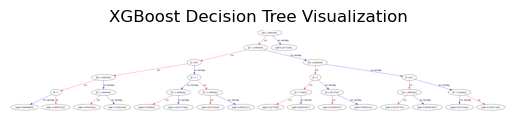

Tree visualization saved as 'xgboost_tree_visualization.png'


In [6]:
import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
    gamma=0.1,                    
    random_state=42
)

xgb_model.fit(X, y)

# Print model accuracy
overall_accuracy = xgb_model.score(X, y)
print(f"Overall Training Accuracy: {overall_accuracy:.4f}")

# Extract tree dump
booster = xgb_model.get_booster()
tree_dump = booster.get_dump()[0]  # Extract first tree

# Get feature names from DataFrame
feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

# Function to fix thresholds and convert leaf values into class labels
def fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names):
    formatted_rules = []
    indent = "    "

    for line in tree_dump.split("\n"):
        if line.strip():
            depth = line.count("\t")
            formatted_line = line.replace("\t", indent)

            # Replace feature indices (f0, f1, ...) with actual feature names
            for i, feature in enumerate(feature_names):
                formatted_line = formatted_line.replace(f"f{i}<", f"{feature} < ")
                formatted_line = formatted_line.replace(f"f{i}>", f"{feature} > ")

            # Fix incorrect thresholds (< 2.00001001 → < 0.5)
            formatted_line = re.sub(r"<\s*2\.00001001", "< 0.5", formatted_line)
            formatted_line = re.sub(r">=\s*2\.00001001", ">= 0.5", formatted_line)

            # Convert leaf values into class labels
            match = re.search(r"leaf=([-+]?\d*\.\d+)", formatted_line)
            if match:
                logit = float(match.group(1))
                probability = 1 / (1 + np.exp(-logit))  # Convert log-odds to probability
                predicted_class = 1 if probability > 0.5 else 0  # Assign class
                formatted_line = re.sub(r"leaf=[-+]?\d*\.\d+", f"class: {predicted_class}", formatted_line)

            formatted_line = formatted_line.replace("[", "|--- ").replace("]", "")
            formatted_rules.append(indent * depth + formatted_line)

    return "\n".join(formatted_rules)

# Apply the function
formatted_tree = fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names)

# Print fixed tree
print("\nFixed XGBoost Decision Tree with Class Labels:")
print(formatted_tree)

# Save the fixed tree to a new file
with open("xgboost_tree_fixed_with_classes.txt", "w") as file:
    file.write(formatted_tree)

print("Tree rules saved to 'xgboost_tree_fixed_with_classes.txt'")

plt.figure(figsize=(40, 20))
xgb.plot_tree(xgb_model, num_trees=0)
plt.title("XGBoost Decision Tree Visualization")
plt.savefig("xgboost_tree_visualization.png", dpi=300)
plt.show()

print("Tree visualization saved as 'xgboost_tree_visualization.png'")

In [6]:
# Train XGBoost model with optimized parameters
xgb_model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,          
    scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
    gamma=0.1,                     
    random_state=42
)

xgb_model.fit(X, y)

# Print model accuracy
overall_accuracy = xgb_model.score(X, y)
print(f"Overall Training Accuracy: {overall_accuracy:.4f}")

# =========================== #
#  EXTRACT TREE RULES AS TEXT #
# =========================== #

# Extract tree dump
booster = xgb_model.get_booster()
tree_dump = booster.get_dump()[0]  # Extract first tree

# Get feature names from DataFrame
feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

# Function to fix thresholds and convert leaf values into class labels
def fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names):
    formatted_rules = []
    indent = "    "

    for line in tree_dump.split("\n"):
        if line.strip():
            depth = line.count("\t")
            formatted_line = line.replace("\t", indent)

            # Replace feature indices (f0, f1, ...) with actual feature names
            for i, feature in enumerate(feature_names):
                formatted_line = formatted_line.replace(f"f{i}<", f"{feature} < ")
                formatted_line = formatted_line.replace(f"f{i}>", f"{feature} > ")

            # Fix incorrect thresholds (< 2.00001001 → < 0.5)
            formatted_line = re.sub(r"<\s*2\.00001001", "< 0.5", formatted_line)
            formatted_line = re.sub(r">=\s*2\.00001001", ">= 0.5", formatted_line)

            # Convert leaf values into class labels
            match = re.search(r"leaf=([-+]?\d*\.\d+)", formatted_line)
            if match:
                logit = float(match.group(1))
                probability = 1 / (1 + np.exp(-logit))  # Convert log-odds to probability
                predicted_class = 1 if probability > 0.5 else 0  # Assign class
                formatted_line = re.sub(r"leaf=[-+]?\d*\.\d+", f"class: {predicted_class}", formatted_line)

            formatted_line = formatted_line.replace("[", "|--- ").replace("]", "")
            formatted_rules.append(indent * depth + formatted_line)

    return "\n".join(formatted_rules)

# Apply the function
formatted_tree = fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names)

# Save the fixed tree to a new file
with open("xgboost_tree_fixed_with_classes.txt", "w") as file:
    file.write(formatted_tree)

print("Tree rules saved to 'xgboost_tree_fixed_with_classes.txt'")

# =========================== #
#  IDENTIFY FEATURE DEPENDENCIES #
# =========================== #

# Dictionary to store feature dependencies
feature_dependency = defaultdict(list)

# Extract feature dependencies leading to `class: 1`
def extract_feature_dependencies(tree_rules):
    current_path = []  # Stack to keep track of conditions in the path

    for line in tree_rules.split("\n"):
        if not line.strip():
            continue

        # Count depth based on indentation
        depth = line.count("|---")
        line_content = line.replace("|--- ", "").strip()

        # Handle decision nodes (conditions)
        if "class: 1" not in line_content and "class: 0" not in line_content:
            # Extract feature and threshold
            match = re.search(r"(.*?) (<|>) ([0-9\.]+)", line_content)
            if match:
                feature, operator, threshold = match.groups()
                condition = f"{feature} {operator} {threshold}"

                # Update path stack
                if depth < len(current_path):
                    current_path = current_path[:depth]  # Remove deeper nodes
                current_path.append(condition)

        # Handle leaf nodes (class 1)
        elif "class: 1" in line_content:
            # Store all conditions leading to class 1
            for condition in current_path:
                feature_name = condition.split(" ")[0]
                feature_dependency[feature_name].append(condition)

    return feature_dependency

# Extract dependencies
feature_dependencies = extract_feature_dependencies(formatted_tree)

# Save reasons to a file
with open("non_renewal_reasons.txt", "w") as file:
    for feature, conditions in feature_dependencies.items():
        file.write(f"{feature} influences non-renewal due to:\n")
        for condition in set(conditions):
            file.write(f"   - {condition}\n")
        file.write("-" * 60 + "\n")

print("\nReasons for Non-Renewal saved to 'non_renewal_reasons.txt'")

Overall Training Accuracy: 0.6818
Tree rules saved to 'xgboost_tree_fixed_with_classes.txt'

Reasons for Non-Renewal saved to 'non_renewal_reasons.txt'


In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
from collections import defaultdict

# Set number of runs to collect multiple trees
NUM_RUNS = 5  # Run model multiple times to collect different trees

# Store all non-renewal conditions
all_feature_dependencies = defaultdict(list)

# Train the model multiple times to extract all possible decision paths
for run in range(NUM_RUNS):
    print(f"\n🔄 Training XGBoost Model - Run {run + 1}/{NUM_RUNS}")

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(
        max_depth=5,                  
        learning_rate=0.05,            
        n_estimators=200,              
        subsample=0.8,                 
        colsample_bytree=0.8,          
        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
        gamma=0.1,                     
        random_state=run  # Changing random state slightly for each run
    )

    xgb_model.fit(X, y)

    # Extract tree dump
    booster = xgb_model.get_booster()
    tree_dump = booster.get_dump()[0]  # Extract first tree

    # Get feature names
    feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

    # Function to fix thresholds and extract decision rules
    def fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names):
        formatted_rules = []
        indent = "    "
        current_path = []

        for line in tree_dump.split("\n"):
            if line.strip():
                depth = line.count("\t")
                formatted_line = line.replace("\t", indent)

                # Replace feature indices (f0, f1, ...) with actual feature names
                for i, feature in enumerate(feature_names):
                    formatted_line = formatted_line.replace(f"f{i}<", f"{feature} < ")
                    formatted_line = formatted_line.replace(f"f{i}>", f"{feature} > ")

                # Extract feature and threshold from decision nodes
                match = re.search(r"(.*?) (<|>) ([0-9\.]+)", formatted_line)
                if match:
                    feature, operator, threshold = match.groups()
                    condition = f"{feature} {operator} {threshold}"

                    # Update path stack
                    if depth < len(current_path):
                        current_path = current_path[:depth]  # Remove deeper nodes
                    current_path.append(condition)

                # Convert leaf values into class labels
                if "leaf=" in formatted_line:
                    match = re.search(r"leaf=([-+]?\d*\.\d+)", formatted_line)
                    if match:
                        logit = float(match.group(1))
                        probability = 1 / (1 + np.exp(-logit))
                        predicted_class = 1 if probability > 0.5 else 0

                        if predicted_class == 1:
                            for condition in current_path:
                                feature_name = condition.split(" ")[0]
                                all_feature_dependencies[feature_name].append(condition)

        return "\n".join(formatted_rules)

    # Extract tree rules and update dependencies
    fix_xgb_tree_thresholds_and_labels(tree_dump, feature_names)

# =========================== #
#  SAVE FINAL LIST OF REASONS #
# =========================== #

output_file = "non_renewal_reasons_all_runs.txt"
with open(output_file, "w") as file:
    file.write("🔹 **All Possible Non-Renewal Reasons Across Multiple Runs**:\n")
    file.write("=" * 90 + "\n\n")

    for feature, conditions in all_feature_dependencies.items():
        file.write(f"🔸 **{feature}** influences non-renewal due to:\n")
        for condition in set(conditions):  # Remove duplicates
            file.write(f"   - {condition}\n")
        file.write("-" * 90 + "\n")

print(f"\n✅ All possible non-renewal reasons saved to '{output_file}'")


🔄 Training XGBoost Model - Run 1/5

🔄 Training XGBoost Model - Run 2/5

🔄 Training XGBoost Model - Run 3/5

🔄 Training XGBoost Model - Run 4/5

🔄 Training XGBoost Model - Run 5/5

✅ All possible non-renewal reasons saved to 'non_renewal_reasons_all_runs.txt'


In [7]:
import re
from collections import defaultdict

# Load the tree rules from the file
file_path = "xgboost_tree_fixed_with_classes.txt"

with open(file_path, "r") as file:
    tree_rules = file.readlines()

# Dictionary to store feature dependencies and their frequency
feature_threshold_counts = defaultdict(lambda: {"<": defaultdict(int), ">=": defaultdict(int)})

# Parse tree and extract rules leading to `class: 1`
def extract_non_renewal_conditions(tree_rules):
    current_path = []  # Stack to track decision path

    for line in tree_rules:
        line = line.strip()
        if not line:
            continue

        depth = line.count("|---")
        line_content = line.replace("|--- ", "").strip()

        # Handle decision nodes (conditions)
        match = re.search(r"([A-Za-z0-9_ ]+) (<|>) ([0-9\.]+) yes=(\d+),no=(\d+)", line_content)
        if match:
            feature, operator, threshold, yes_branch, no_branch = match.groups()
            threshold = float(threshold)

            # Identify `<` (left) or `>=` (right) branch
            current_path.append((depth, feature, operator, threshold, yes_branch, no_branch))

        # Handle leaf nodes (class 1)
        elif "class: 1" in line_content:
            # Find the decision path leading to `class: 1`
            for depth, feature, operator, threshold, yes_branch, no_branch in current_path:
                if str(yes_branch) in line:  # If class: 1 is in the left branch, `<` is important
                    feature_threshold_counts[feature]["<"][threshold] += 1
                elif str(no_branch) in line:  # If class: 1 is in the right branch, `>=` is important
                    feature_threshold_counts[feature][">="][threshold] += 1

    return feature_threshold_counts

# Extract dependencies and their frequency
feature_threshold_counts = extract_non_renewal_conditions(tree_rules)

# Save reasons to a file
output_file = "non_renewal_thresholds.txt"

with open(output_file, "w") as file:
    file.write("🔹 **Key Non-Renewal Conditions (Most Frequent Thresholds)**:\n")
    file.write("=" * 80 + "\n\n")

    for feature, threshold_data in feature_threshold_counts.items():
        most_common_less_than = max(threshold_data["<"], key=threshold_data["<"].get, default=None)
        most_common_greater_than = max(threshold_data[">="], key=threshold_data[">="].get, default=None)

        file.write(f"🔸 **{feature}** influences non-renewal due to:\n")
        if most_common_less_than is not None:
            file.write(f"   - {feature} < {most_common_less_than} (Most Common for Non-Renewal)\n")
        if most_common_greater_than is not None:
            file.write(f"   - {feature} >= {most_common_greater_than} (Most Common for Non-Renewal)\n")
        file.write("-" * 80 + "\n")

print(f"\n✅ Updated non-renewal thresholds saved to '{output_file}'")


✅ Updated non-renewal thresholds saved to 'non_renewal_thresholds.txt'


In [8]:
import re
from collections import defaultdict

# Load the tree rules from the file
file_path = "xgboost_tree_fixed_with_classes.txt"

with open(file_path, "r") as file:
    tree_rules = file.readlines()

# Dictionary to store feature dependencies and their frequency
feature_threshold_counts = defaultdict(lambda: {"<": defaultdict(int), ">=": defaultdict(int)})

# Parse tree and extract rules leading to `class: 1`
def extract_non_renewal_conditions(tree_rules):
    current_path = []  # Stack to track decision path

    for line in tree_rules:
        line = line.strip()
        if not line:
            continue

        depth = line.count("|---")
        line_content = line.replace("|--- ", "").strip()

        # Handle decision nodes (conditions)
        match = re.search(r"([A-Za-z0-9_ ]+) (<|>) ([0-9\.]+) yes=(\d+),no=(\d+)", line_content)
        if match:
            feature, operator, threshold, yes_branch, no_branch = match.groups()
            threshold = float(threshold)

            # Identify `<` (left) or `>=` (right) branch
            current_path.append((depth, feature, operator, threshold, yes_branch, no_branch))

        # Handle leaf nodes (class 1)
        elif "class: 1" in line_content:
            # Find the decision path leading to `class: 1`
            for depth, feature, operator, threshold, yes_branch, no_branch in current_path:
                if str(yes_branch) in line:  # If class: 1 is in the left branch, `<` is important
                    feature_threshold_counts[feature]["<"][threshold] += 1
                elif str(no_branch) in line:  # If class: 1 is in the right branch, `>=` is important
                    feature_threshold_counts[feature][">="][threshold] += 1

    return feature_threshold_counts

# Extract dependencies and their frequency
feature_threshold_counts = extract_non_renewal_conditions(tree_rules)

# Save reasons to a file
output_file = "filtered_non_renewal_thresholds.txt"

with open(output_file, "w") as file:
    file.write("🔹 **Key Non-Renewal Conditions (Filtered for Most Important Condition Only)**:\n")
    file.write("=" * 90 + "\n\n")

    for feature, threshold_data in feature_threshold_counts.items():
        # Find the most frequent threshold for both `<` and `>=`
        most_common_less_than = max(threshold_data["<"], key=threshold_data["<"].get, default=None)
        most_common_greater_than = max(threshold_data[">="], key=threshold_data[">="].get, default=None)

        less_than_count = threshold_data["<"].get(most_common_less_than, 0)
        greater_than_count = threshold_data[">="].get(most_common_greater_than, 0)

        file.write(f"🔸 **{feature}** influences non-renewal due to:\n")

        # Only include the condition with a higher count
        if less_than_count > greater_than_count:
            file.write(f"   - {feature} < {most_common_less_than} (Most Frequent Condition)\n")
        elif greater_than_count > less_than_count:
            file.write(f"   - {feature} >= {most_common_greater_than} (Most Frequent Condition)\n")
        else:
            file.write(f"   - {feature} < {most_common_less_than} and >= {most_common_greater_than} (Equal Frequency, Review Needed)\n")

        file.write("-" * 90 + "\n")

print(f"\n✅ Updated non-renewal thresholds saved to '{output_file}'")


✅ Updated non-renewal thresholds saved to 'filtered_non_renewal_thresholds.txt'


In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
from collections import defaultdict

# Set number of runs to collect multiple trees
NUM_RUNS = 5  # Run model multiple times to collect different trees

# Store all non-renewal conditions
all_feature_dependencies = defaultdict(list)

# Train the model multiple times to extract all possible decision paths
for run in range(NUM_RUNS):
    print(f"\n🔄 Training XGBoost Model - Run {run + 1}/{NUM_RUNS}")

   # Train XGBoost model
    xgb_model = xgb.XGBClassifier(
        max_depth=5,                  
        learning_rate=0.05,            
        n_estimators=200,              
        subsample=0.8,                 
        colsample_bytree=0.8,          
        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
        gamma=0.1,                     
        random_state=run  # Changing random state slightly for each run
    ) 

    xgb_model.fit(X, y)

    # Extract tree dump
    booster = xgb_model.get_booster()
    tree_dump = booster.get_dump()[0]  # Extract first tree

    # Get feature names
    feature_names = df_selected.drop(columns=['Status_Binary']).columns.tolist()

    # Function to format XGBoost tree properly
    def format_xgb_tree(tree_dump, feature_names):
        formatted_rules = []
        indent = "    "  # 4 spaces for indentation
        current_path = []

        for line in tree_dump.split("\n"):
            if line.strip():  # Skip empty lines
                depth = line.count("\t")  # Count tab indentation
                formatted_line = line.replace("\t", indent)  # Replace tabs with spaces

                # Replace feature indices (f0, f1, ...) with actual feature names
                for i, feature in enumerate(feature_names):
                    formatted_line = formatted_line.replace(f"f{i}<", f"{feature} < ")
                    formatted_line = formatted_line.replace(f"f{i}>", f"{feature} > ")

                # Ensure decision nodes are correctly formatted
                formatted_line = formatted_line.replace("[", "|--- ").replace("]", "")

                formatted_rules.append(indent * depth + formatted_line)

        return "\n".join(formatted_rules)

    # Apply the function
    formatted_tree = format_xgb_tree(tree_dump, feature_names)

    # Save the formatted tree for this run
    with open(f"xgboost_tree_run_{run+1}.txt", "w") as file:
        file.write(formatted_tree)

    print(f"📜 Decision tree for Run {run+1} saved as 'xgboost_tree_run_{run+1}.txt'")


🔄 Training XGBoost Model - Run 1/5
📜 Decision tree for Run 1 saved as 'xgboost_tree_run_1.txt'

🔄 Training XGBoost Model - Run 2/5
📜 Decision tree for Run 2 saved as 'xgboost_tree_run_2.txt'

🔄 Training XGBoost Model - Run 3/5
📜 Decision tree for Run 3 saved as 'xgboost_tree_run_3.txt'

🔄 Training XGBoost Model - Run 4/5
📜 Decision tree for Run 4 saved as 'xgboost_tree_run_4.txt'

🔄 Training XGBoost Model - Run 5/5
📜 Decision tree for Run 5 saved as 'xgboost_tree_run_5.txt'


In [12]:
import re
from collections import defaultdict

# Load the tree rules from the file
file_path = "xgboost_tree_run_1.txt"

with open(file_path, "r") as file:
    tree_rules = file.readlines()

# Dictionary to store feature dependencies and their frequency
feature_threshold_counts = defaultdict(lambda: {"<": defaultdict(int), ">=": defaultdict(int)})

# Extract non-renewal conditions
def extract_non_renewal_conditions(tree_rules):
    current_path = []  # Stack to track decision path

    for line in tree_rules:
        line = line.strip()
        if not line:
            continue

        depth = line.count("|---")
        line_content = line.replace("|--- ", "").strip()

        # Check if this is a decision node (contains a threshold condition)
        match = re.search(r"([A-Za-z0-9_ ]+) (<|>) ([0-9\.]+) yes=(\d+),no=(\d+)", line_content)
        if match:
            feature, operator, threshold, yes_branch, no_branch = match.groups()
            threshold = float(threshold)

            # Update path stack to maintain correct tree structure
            if depth < len(current_path):
                current_path = current_path[:depth]  # Remove deeper nodes
            current_path.append((feature, operator, threshold, yes_branch, no_branch))

        # If we reach `class: 1`, save the full decision path
        elif "class: 1" in line_content:
            for feature, operator, threshold, yes_branch, no_branch in current_path:
                feature_threshold_counts[feature][operator][threshold] += 1

    return feature_threshold_counts

# Run extraction
feature_threshold_counts = extract_non_renewal_conditions(tree_rules)

# Save results
output_file = "filtered_non_renewal_thresholds.txt"

with open(output_file, "w") as file:
    file.write("🔹 **Key Non-Renewal Conditions (Filtered for Most Important Condition Only)**:\n")
    file.write("=" * 90 + "\n\n")

    for feature, threshold_data in feature_threshold_counts.items():
        # Find the most frequent threshold for both `<` and `>=`
        most_common_less_than = max(threshold_data["<"], key=threshold_data["<"].get, default=None)
        most_common_greater_than = max(threshold_data[">="], key=threshold_data[">="].get, default=None)

        less_than_count = threshold_data["<"].get(most_common_less_than, 0)
        greater_than_count = threshold_data[">="].get(most_common_greater_than, 0)

        file.write(f"🔸 **{feature}** influences non-renewal due to:\n")

        # Only include the condition with a higher count
        if less_than_count > greater_than_count:
            file.write(f"   - {feature} < {most_common_less_than} (Most Frequent Condition)\n")
        elif greater_than_count > less_than_count:
            file.write(f"   - {feature} >= {most_common_greater_than} (Most Frequent Condition)\n")
        else:
            file.write(f"   - {feature} < {most_common_less_than} and >= {most_common_greater_than} (Equal Frequency, Review Needed)\n")

        file.write("-" * 90 + "\n")

print(f"\n✅ Updated non-renewal thresholds saved to '{output_file}'")



✅ Updated non-renewal thresholds saved to 'filtered_non_renewal_thresholds.txt'


In [ ]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),  
    gamma=0.1,                    
    random_state=42
)

model.fit(X, y)

# Evaluate the Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=df_selected.drop(columns=['Status_Binary']).columns)

print("Feature Importance (all features):")
print(feature_importances)

# Plot the Feature importance graph
plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index, palette="coolwarm")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

feature_importances_df = pd.DataFrame({'Feature': feature_importances.index, 'Importance': feature_importances.values})
feature_importances_df.to_csv('feature_importances_xgb.csv', index=False)